# Validation of the inferred interactome

---

## 0. Environmental setup

In [137]:
import numpy as np
import pandas as pd
import networkx as nx
import community
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, rand_score, adjusted_mutual_info_score
from tqdm import tqdm
seed = 1234
np.random.seed(seed)
import seaborn as sns

import random
random.seed(1234)

In [82]:
def compute_adjusted_randidx_matrix(signature_clusters, graph_clusters):
    adjusted_randidx = np.zeros([len(signature_clusters), len(graph_clusters)])
    for i in tqdm(range(len(signature_clusters)), desc="Compute adj.RandIndex"):
        for j in range(len(graph_clusters)):
            signature_cluster = list(signature_clusters.values())[i]
            graph_cluster = list(graph_clusters.values())[j]
            adjusted_randidx[i,j] = adjusted_rand_score(signature_cluster, graph_cluster)
    return adjusted_randidx

## 1. Read in data

In [122]:
morph_embs = pd.read_csv("../../../data/images/metadata/nuclei_profiles_hoechst_cleaned.csv", index_col = 0)

In [149]:
median_profiles = morph_embs.groupby("labels").mean().drop("EMPTY")

In [170]:
l5_signatures = pd.read_csv("../../../data/gex/cmap/filtered_l5_data_u2os.csv", index_col=0)
l5_signatures = l5_signatures.loc[l5_signatures["target"]!="UnTrt"]
l5_signatures = l5_signatures.groupby("target").mean()
l5_signatures

,CAMSAP2,PPP2R5A,CISD1,AKAP8,TMEM109,CHAC1,FOS,ORC1,AARS,MLLT11,...,ABCF1,SERPINE1,HLA-DMA,STK10,BLCAP,ASCC3,KDELR2,HIST2H2BE,MELK,SMARCA4
target,,,,,,,,,,,,,,,,,,,,,
ACVR1B,-0.655167,-0.396750,0.331467,0.210683,0.514150,-0.159000,0.624683,-0.190117,-0.085033,0.303417,...,0.199633,0.505433,0.127283,-0.197517,0.116783,0.468083,-0.115700,-0.703183,1.093517,0.179967
ADAM17,0.254800,0.040200,-0.251950,-0.434400,0.077000,-0.014950,-0.036950,-1.055250,0.300150,0.283800,...,0.217550,-0.172350,-0.335450,-0.569100,-0.741500,0.278500,-0.040350,0.719400,-0.134250,0.859750
AKT1,-0.316983,-1.004300,0.054283,-0.170033,0.121950,-0.199067,-0.306967,-0.229017,-0.404150,0.809800,...,0.043800,0.421250,0.863717,-0.351917,0.348333,0.346150,0.200217,-0.373067,-0.345750,0.461600
AKT1S1,-0.279350,-1.578925,-0.231600,0.484600,-0.066150,-0.453650,-0.468950,0.062200,-1.380075,-0.571250,...,-0.044450,1.642675,-0.222175,2.352925,-0.783325,0.478025,-0.321900,-0.508475,0.145675,1.385150
AKT2,-1.120450,0.011550,0.044450,1.121250,0.783850,-0.329950,-0.623600,-0.507700,-0.070500,1.409200,...,0.031650,1.131150,0.135300,1.086600,-0.540200,-0.258800,1.202250,-0.479050,0.251100,0.092850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VHL,-0.502725,-0.113050,-0.291275,-0.217225,0.385100,0.217425,1.646875,-0.902000,0.434925,-0.120350,...,0.002075,0.539775,0.200750,-0.185000,0.727400,0.230875,0.156575,-0.303300,0.091225,-0.333700
WWTR1,-1.703150,0.548250,-0.748500,0.202400,-0.669150,-0.449450,-0.785300,-0.334300,-0.990450,0.369600,...,-0.371200,-0.655400,0.337250,-0.421750,0.015400,0.365000,0.486250,-0.554250,0.632500,1.310250
XBP1,0.375625,-0.952575,0.676050,0.653825,-0.211475,-0.128275,0.201275,0.601525,0.375450,0.826475,...,-0.196100,-0.027050,-0.292575,0.332575,-0.223800,-0.703625,0.691350,0.388600,0.238750,-0.030825


In [172]:
targets = list(l5_signatures.index)

In [175]:
pcst = nx.read_gpickle("../../../data/ppi/pcst_ccle_abslogfc_orf_max_spearman_r_b_1.pkl")
print(nx.info(pcst))

Name: Confidence_Pruned_CCLE_absLogFC_ORF_max_Spearman_p_b_1
Type: Graph
Number of nodes: 3408
Number of edges: 3407
Average degree:   1.9994


In [176]:
median_profiles= median_profiles.loc[targets]

In [177]:
def compute_target_dist_mtx(pcst, targets):
    n = len(targets)
    dist_mtx = np.zeros([n,n])
    for i in tqdm(range(0, n-1)):
        for j in range(i+1, n):
            dist_mtx[i,j]=nx.shortest_path_length(pcst, targets[i], targets[j], weight="spearmanr")
    dist_mtx = dist_mtx + dist_mtx.transpose()
    return dist_mtx

In [178]:
pcst_dist_mtx = compute_target_dist_mtx(pcst, targets)

100%|██████████| 163/163 [00:53<00:00,  3.05it/s]


---

## 2. Clustering

### Agglomerative correlation similarity

In [179]:
signature_clusters = dict()
for i in tqdm(range(1, len(l5_signatures)+1), desc="Compute signature clusters"):
    ac = AgglomerativeClustering(linkage='average', n_clusters=i, affinity=pearson_affinity)
    signature_clusters[i] = ac.fit_predict(l5_signatures.iloc[:,:-1])

Compute signature clusters: 100%|██████████| 164/164 [03:44<00:00,  1.37s/it]


### Agglomerative shortest path similarity

In [180]:
graph_clusters = dict()
for i in tqdm(range(1, len(l5_signatures) +1), desc="Compute graph clusters"):
    ac = AgglomerativeClustering(linkage="average", n_clusters=i, affinity="precomputed")
    graph_clusters[i] = ac.fit_predict(pcst_dist_mtx)

Compute graph clusters: 100%|██████████| 164/164 [00:00<00:00, 1125.62it/s]


### Agglomerative morph similarity

In [181]:
drop_columns = [
    "Nuclei_AreaShape_Center_X",
    "Nuclei_AreaShape_Center_Y",
    "Nuclei_Location_CenterMassIntensity_X_Hoechst",
    "Nuclei_Location_CenterMassIntensity_Y_Hoechst",
    "Nuclei_Location_Center_X",
    "Nuclei_Location_Center_Y",
    "Nuclei_Location_MaxIntensity_X_Hoechst",
    "Nuclei_Location_MaxIntensity_X_Hoechst",
    "Nuclei_Neighbors_FirstClosestObjectNumber_1",
    "Nuclei_Neighbors_SecondClosestObjectNumber_1",
    "Nuclei_AreaShape_Orientation",
]
median_profiles = median_profiles.drop(columns=drop_columns)

KeyError: "['Nuclei_AreaShape_Center_X' 'Nuclei_AreaShape_Center_Y'\n 'Nuclei_Location_CenterMassIntensity_X_Hoechst'\n 'Nuclei_Location_CenterMassIntensity_Y_Hoechst'\n 'Nuclei_Location_Center_X' 'Nuclei_Location_Center_Y'\n 'Nuclei_Location_MaxIntensity_X_Hoechst'\n 'Nuclei_Location_MaxIntensity_X_Hoechst'\n 'Nuclei_Neighbors_FirstClosestObjectNumber_1'\n 'Nuclei_Neighbors_SecondClosestObjectNumber_1'\n 'Nuclei_AreaShape_Orientation'] not found in axis"

In [ ]:
from scipy.stats import pearsonr
def pearson_affinity(M):
    return 1 - np.array([[pearsonr(a,b)[0] for a in M] for b in M])

In [182]:
morph_clusters = dict()
for i in tqdm(range(1, len(median_profiles)+1), desc="Compute morph clusters"):
    ac = AgglomerativeClustering(linkage='average', n_clusters=i, affinity=pearson_affinity)
    morph_clusters[i] = ac.fit_predict(MinMaxScaler().fit_transform(median_profiles.iloc[:,:-1]))

Compute morph clusters: 100%|██████████| 164/164 [02:48<00:00,  1.03s/it]


### Compute adjusted RandIndex

In [183]:
adjusted_randidx_matrix = compute_adjusted_randidx_matrix(signature_clusters, morph_clusters)

Compute adj.RandIndex: 100%|██████████| 164/164 [00:11<00:00, 14.14it/s]


<AxesSubplot:>

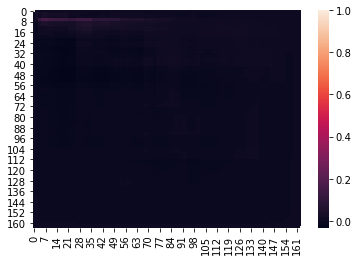

In [184]:
sns.heatmap(adjusted_randidx_matrix)

In [190]:
"BCL2L1" in targets

True

In [193]:
sns.heatmap(pearson_affinity(l5_signatures.loc[["BCL2L1", "BCL2L11", "DDIT3", "GRB10"]]))

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [210]:
import matplotlib.pyplot as plt

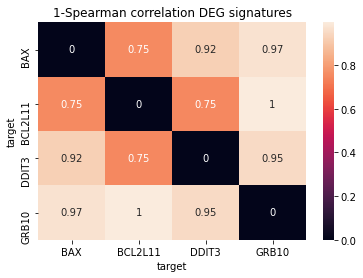

In [212]:
sns.heatmap(1 - l5_signatures.loc[["BAX", "BCL2L11", "DDIT3", "GRB10"]].transpose().corr(method="spearman").abs(), annot=True)
plt.title("1-Spearman correlation DEG signatures")
plt.show()

<AxesSubplot:>

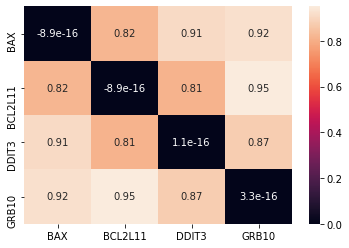

In [205]:
from sklearn.metrics.pairwise import cosine_similarity
sns.heatmap(pd.DataFrame(1-cosine_similarity(l5_signatures.loc[["BAX", "BCL2L11", "DDIT3", "GRB10"]]), index=["BAX", "BCL2L11", "DDIT3", "GRB10"], columns=["BAX", "BCL2L11", "DDIT3", "GRB10"]), annot=True)